## Model Experimentation

In [10]:
# Basic Import
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
# Modelling
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor,AdaBoostRegressor
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression, Ridge,Lasso
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.model_selection import RandomizedSearchCV
from lightgbm import LGBMRegressor

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
import warnings

In [3]:
data = pd.read_csv('data/stud.csv')
data.head()

,gender,race_ethnicity,parental_level_of_education,lunch,test_preparation_course,math_score,reading_score,writing_score
0,female,group B,bachelor's degree,standard,none,72,72,74
1,female,group C,some college,standard,completed,69,90,88
2,female,group B,master's degree,standard,none,90,95,93
3,male,group A,associate's degree,free/reduced,none,47,57,44
4,male,group C,some college,standard,none,76,78,75


In [4]:
X = data.drop('math_score', axis=1)
Y = data['math_score']
print(X.shape)
print(Y.shape)

(1000, 7)
(1000,)


In [9]:
num_cols = X.select_dtypes(exclude='object').columns
cat_cols = X.select_dtypes(include='object').columns
print(num_cols)
print(cat_cols)

Index(['reading_score', 'writing_score'], dtype='object')
Index(['gender', 'race_ethnicity', 'parental_level_of_education', 'lunch',
       'test_preparation_course'],
      dtype='object')


Transforming Numerical and Categorical features

In [11]:
scaler = StandardScaler()
ohe = OneHotEncoder()
column_transformer = ColumnTransformer(
    [('ohe', ohe, cat_cols),
     ('scaler', scaler, num_cols)]
)

In [24]:
data_X = column_transformer.fit_transform(X)
data_X = pd.DataFrame(data_X)
print(data_X.shape)
data_X.head()


(1000, 19)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.193999,0.391492
1,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.427476,1.313269
2,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.770109,1.642475
3,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,-0.833899,-1.583744
4,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.605158,0.457333


In [27]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(data_X, Y, test_size=0.2, random_state=1)
x_train.shape, x_test.shape

((800, 19), (200, 19))

Model Experimentation

In [30]:
models = {'Linear Regression' : LinearRegression(),
        'Lasso Regression' : Lasso(),
        'Ridge Regression' : Ridge(),
        'Decision Trees': DecisionTreeRegressor(),
        'Random Forest' : RandomForestRegressor(),
        'Ada Boosting' : AdaBoostRegressor(),
        'Light GBM' : LGBMRegressor()}

def evaluate(ypred, ytrue):
    abs = mean_absolute_error(ytrue, ypred)
    r2 = r2_score(ytrue, ypred)
    rmse = np.sqrt(mean_squared_error(ytrue, ypred))
    return abs, rmse, r2

model_list = []
test_r2_score=[]
train_r2_score=[]
for name, model in models.items():
    # train
    model.fit(x_train, y_train)
    
    # predict
    y_train_pred = model.predict(x_train)
    y_test_pred = model.predict(x_test)

    # Scores
    train_abs, train_rmse, train_r2 = evaluate(y_train_pred, y_train)
    test_abs, test_rmse, test_r2 = evaluate(y_test_pred, y_test)

    # print(name)
    # print('Model performance for Training set')
    # print("- Root Mean Squared Error: {:.4f}".format(train_rmse))
    # print("- Mean Absolute Error: {:.4f}".format(train_abs))
    # print("- R2 Score: {:.4f}".format(train_r2))

    # print('-'*40)
    # print('Model performance for Testing set')
    # print("- Root Mean Squared Error: {:.4f}".format(test_rmse))
    # print("- Mean Absolute Error: {:.4f}".format(test_abs))
    # print("- R2 Score: {:.4f}".format(test_r2))
    # print('='*40)
    # print('\n')

    model_list.append(name)
    train_r2_score.append(train_r2)
    test_r2_score.append(test_r2)

scores_df = pd.DataFrame({'Model':model_list, 'Train R2 score': train_r2_score, 'Test R2 score':test_r2_score})
scores_df.sort_values('Test R2 score', ascending=False, inplace=True)
scores_df

,Model,Train R2 score,Test R2 score
2,Ridge Regression,0.870611,0.895447
0,Linear Regression,0.869523,0.894536
4,Random Forest,0.976152,0.851367
6,Light GBM,0.938829,0.849947
5,Ada Boosting,0.850259,0.840096
1,Lasso Regression,0.805285,0.829706
3,Decision Trees,0.999920,0.738647


In [32]:
# Refitting Linear Regression model
lin_reg = LinearRegression()
lin_reg.fit(x_train, y_train)
y_pred = lin_reg.predict(x_test)

_, _, r2 = evaluate(y_pred, y_test)
print(f"Accuracy of model is {round(r2*100,2)}%")

Accuracy of model is 89.45%


Text(0, 0.5, 'True Values')

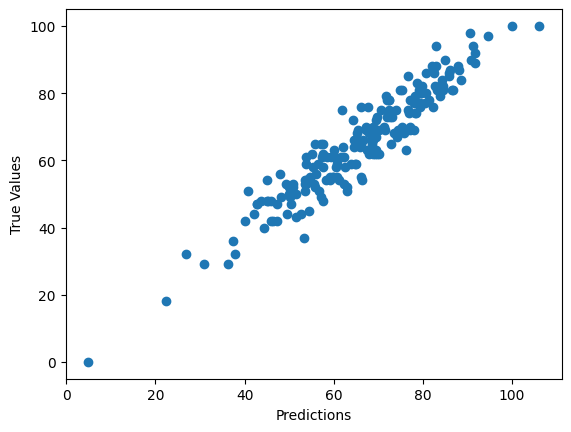

In [34]:
# Scatter Plot - Homo/Hetero Skedacity
plt.scatter(y_pred, y_test)
plt.xlabel('Predictions')
plt.ylabel('True Values')